In [2]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 12

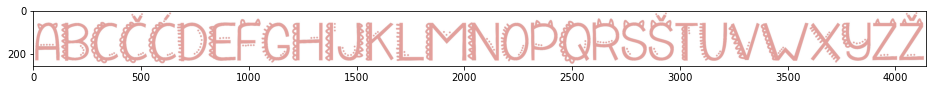

In [85]:
cvimg = cv2.imread('./dataset/train/alphabet0.png')#'dataset/validation/train17.png')#
rgbimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
plt.imshow(rgbimg)

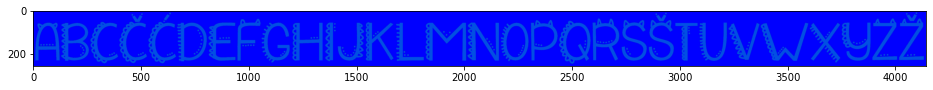

In [86]:
hsvImage = cv2.cvtColor(cvimg, cv2.COLOR_BGR2HSV)
plt.imshow(hsvImage, 'hsv')

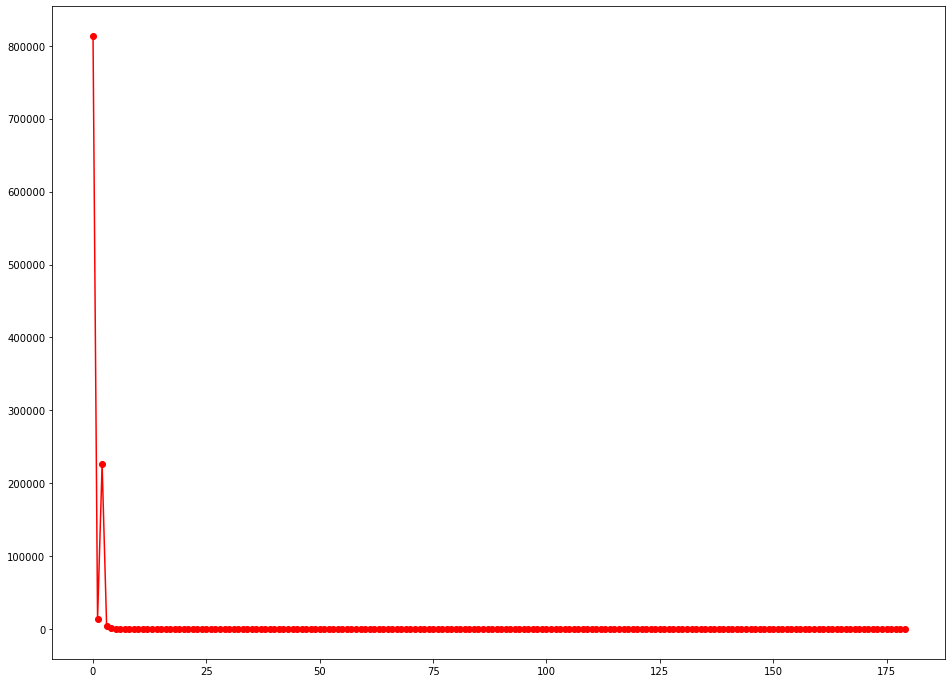

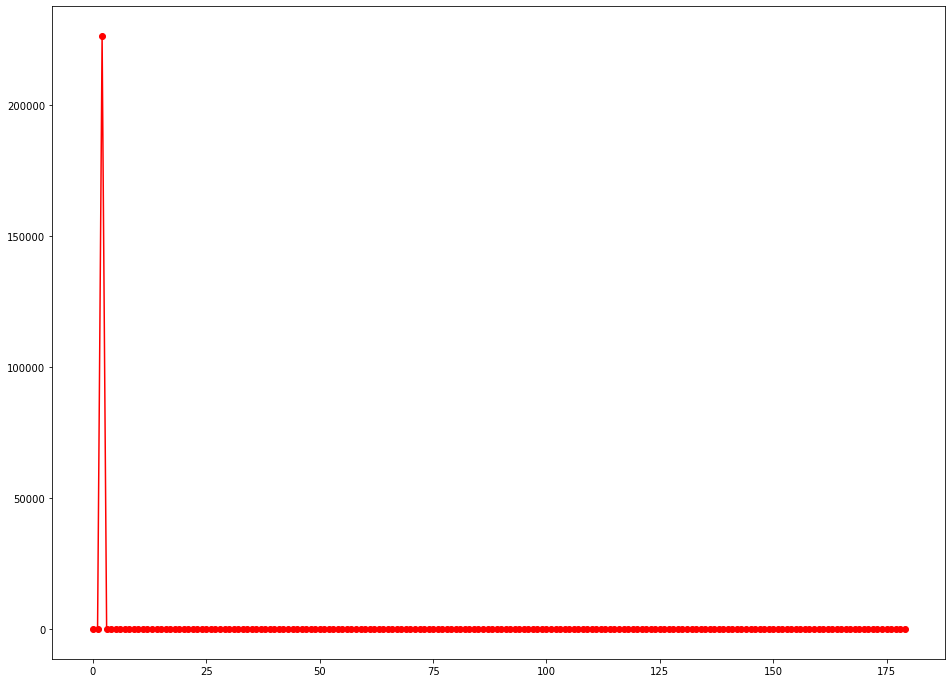

In [87]:
def histogram(image, xmax):
    height, width = image.shape[0:2]
    x = range(0, xmax+1)
    y = np.zeros(xmax+1)
    for i in range(0, height):
        for j in range(0, width):
            pixel = image[i, j]
            y[pixel] += 1
    return x, y
x, y = histogram(hsvImage[:, :, 0], 179)
plt.figure()
plt.plot(x, y, '-or')
pixels = hsvImage.shape[0] * hsvImage.shape[1]
for i in range(len(y)):
    if not 0.05 * pixels < y[i] < 0.3 * pixels:
        y[i] = 0
plt.figure()
plt.plot(x, y, '-or')
plt.show()

[2]
173126.0
149006.0


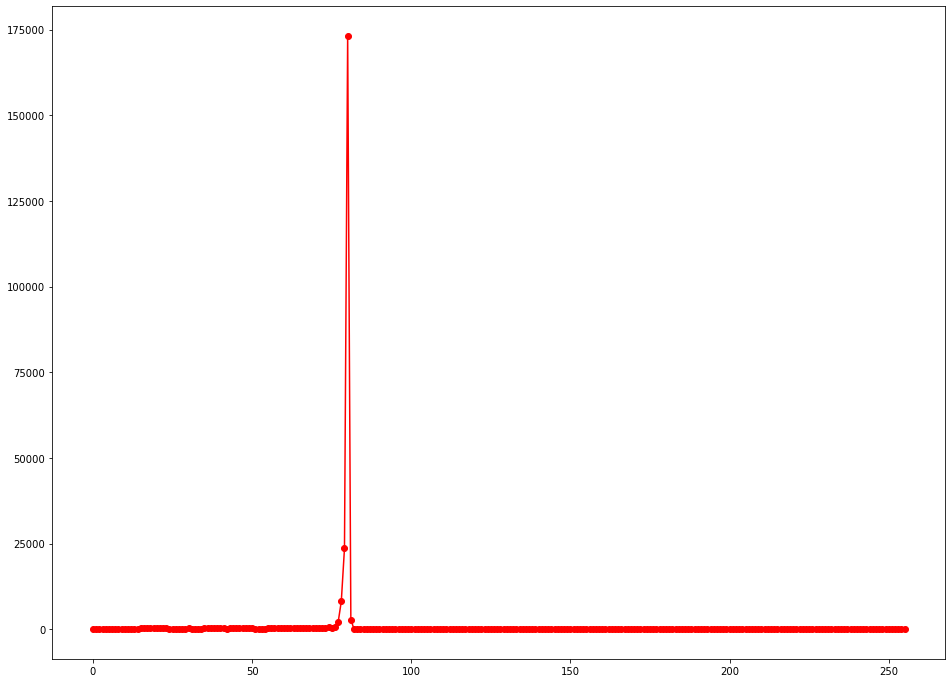

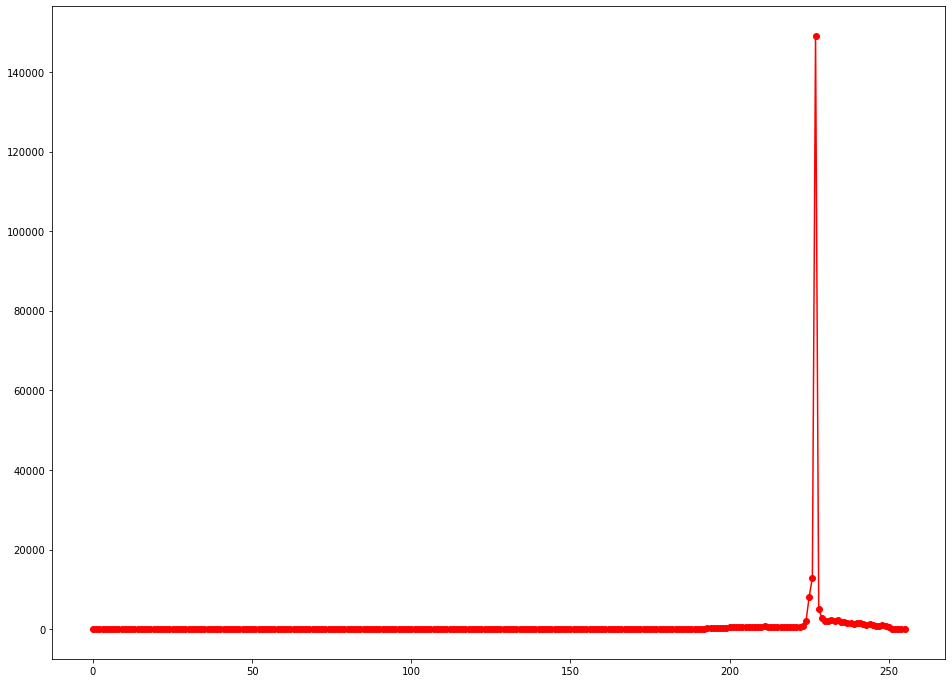

[[2, 80, 227]]


In [88]:
def distinctHist(image, xmax, sourcevalid):
    height, width = image.shape[0:2]
    x = range(0, xmax+1)
    y = np.zeros(xmax+1)
    for i in range(0, height):
        for j in range(0, width):
            if sourcevalid[i, j]:
                pixel = image[i, j]
                y[pixel] += 1
    return x, y
peaks, _ = scipy.signal.find_peaks(y)
print(peaks)
peakcandidate = []
for peak in peaks:
    valid = True
    hsvpeak = [peak]
    for i in range(1,3):
        xtemp, ytemp = distinctHist(hsvImage[:, :, i], 255, hsvImage[:, :, 0] == peak)
        hsvpeak.append(np.argmax(ytemp))
        print(np.amax(ytemp))
        plt.figure()
        plt.plot(xtemp, ytemp, '-or')
        if (i==1 and np.amax(ytemp)<0.3*y[peak]):# or (i==2 and np.amax(ytemp)<0.4*y[peak]):
            valid = False
            break
    if valid:
        peakcandidate.append(hsvpeak)
plt.show()
peakcandidate.sort(key=lambda x: x[2], reverse=True)
print(peakcandidate)

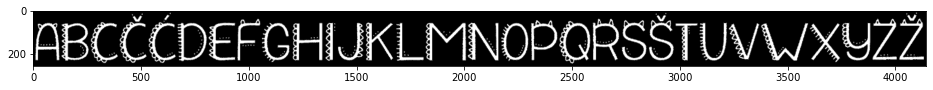

In [89]:
textimg = np.zeros(hsvImage[:,:,0].shape, hsvImage[:,:,0].dtype)
#textimg[np.logical_or(hsvImage[:,:,0]!=peakcandidate[0][0], hsvImage[:,:,1]!=peakcandidate[0][1])] = 0
textimg[np.logical_and(hsvImage[:,:,0]==peakcandidate[0][0], hsvImage[:,:,1]==peakcandidate[0][1])] = 255
plt.imshow(textimg, 'gray')

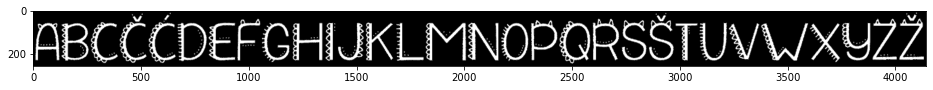

In [90]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closedopentextimg = textimg
#opentextimg = cv2.morphologyEx(textimg,cv2.MORPH_OPEN,kernel, iterations = 1)
#closedopentextimg = cv2.morphologyEx(opentextimg,cv2.MORPH_CLOSE,kernel, iterations = 2)
plt.imshow(closedopentextimg, 'gray')

In [91]:
img, contours, hierarchy = cv2.findContours(closedopentextimg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

4471


2818


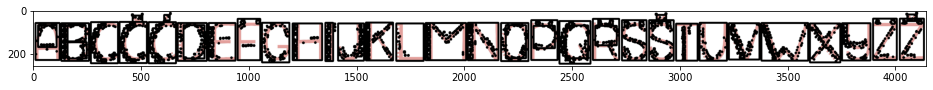

In [92]:
def rectPoints(r):
    pts = [[r[0],r[1]], [r[0],r[1]], [r[0],r[1]], [r[0],r[1]]]
    pts[1][0] = pts[1][0] + r[2]
    pts[2][0] = pts[1][0]
    pts[2][1] = pts[2][1] + r[3]
    pts[3][1] = pts[2][1]
    return pts
contours.sort(key=lambda x: cv2.contourArea(x), reverse = True)
for i in range(0, len(contours)):
    if cv2.contourArea(contours[i]) <= 1:
        contours = contours[:i]
        break
print(len(contours))
imgcpy = rgbimg.copy()
for c in contours:
    r = cv2.boundingRect(c)
    #pts = cv2.boxPoints(r)
    pts = rectPoints(r)
    cv2.drawContours(imgcpy,[cv2.convexHull(np.array([pts[0], pts[1], pts[2], pts[3]], dtype=np.int32))],0,(0,0,0),7)
plt.imshow(imgcpy)
exrects = []
def isInside(rectangle, contour):
    pts = rectPoints(rectangle)
    rectcontour = cv2.convexHull(np.array([pts[0], pts[1], pts[2], pts[3]], dtype=np.int32))
    for coor in contour:
        point = (coor[0][0], coor[0][1])
        if cv2.pointPolygonTest(rectcontour, point, False) < 0:
            return False
    return True
def expandRect(rectangle):
    wxsideshift = 0#int(0.15 * rectangle[2])
    hyupshift = int(0.5 * rectangle[3])
    hydownshift = int(0.15 * rectangle[3])
    rectw = int(2 * wxsideshift + rectangle[2])
    recth = int(hyupshift + hydownshift + rectangle[3])
    rectx = rectangle[0] - wxsideshift
    recty = rectangle[1] - hyupshift
    return (rectx, recty, rectw, recth)
i = 0
while i < len(contours):
    j = i + 1
    done = False
    #for rect in exrects:
    #    if isInside(rect[0], contours[i]):
    #        rect[1].append(contours[i].copy())
    #        del contours[i]
    #        done = True
    #        break
    #if done:
    #    i = i + 1
    #    continue
    exrect = [expandRect(cv2.boundingRect(contours[i])), []]
    while j < len(contours):
        if isInside(exrect[0], contours[j]):
            exrect[1].append(contours[j])
            contours.pop(j)
            continue
        j = j + 1
    exrects.append(exrect)
    i = i + 1
exrects.sort(key=lambda x: x[0][2]*x[0][3], reverse = True)
for i in range(0,len(exrects)):
    if exrects[i][0][2]*exrects[i][0][3] < 0.1 * exrects[0][0][2] * exrects[0][0][3]:#0.05*exrects[0][0][2]*exrects[0][0][3]:
        exrects = exrects[:i]
        break

30


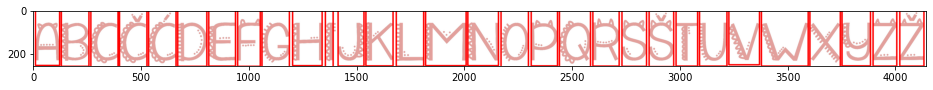

In [93]:
print(len(exrects))
imgcpy = rgbimg.copy()
for x in exrects:
    r = x[0]
    pts = [[r[0],r[1]], [r[0],r[1]], [r[0],r[1]], [r[0],r[1]]]
    pts[1][0] = pts[1][0] + r[2]
    pts[2][0] = pts[1][0]
    pts[2][1] = pts[2][1] + r[3]
    pts[3][1] = pts[2][1]
    cv2.drawContours(imgcpy,[cv2.convexHull(np.array([pts[0], pts[1], pts[2], pts[3]], dtype=np.int32))],-1,(255,0,0),5)
plt.imshow(imgcpy)

[(11, -25, 112, 278), array([], shape=(113, 0), dtype=uint8)]


/home/fmaster/anaconda3/envs/sc-jupy/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/home/fmaster/anaconda3/envs/sc-jupy/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


[0, 11, 6, 8, 0, 20, 29, 0, 5, 116, 0, 3, 14, 0, 54, 27, 18, 0, 33, 21, 12, 25, 0, 0, 0, 84, 17, 34, 12]


/home/fmaster/anaconda3/envs/sc-jupy/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


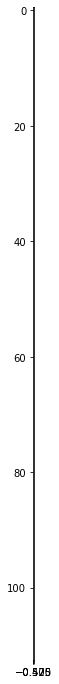

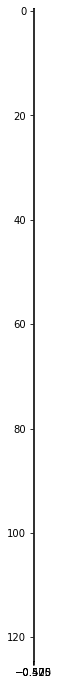

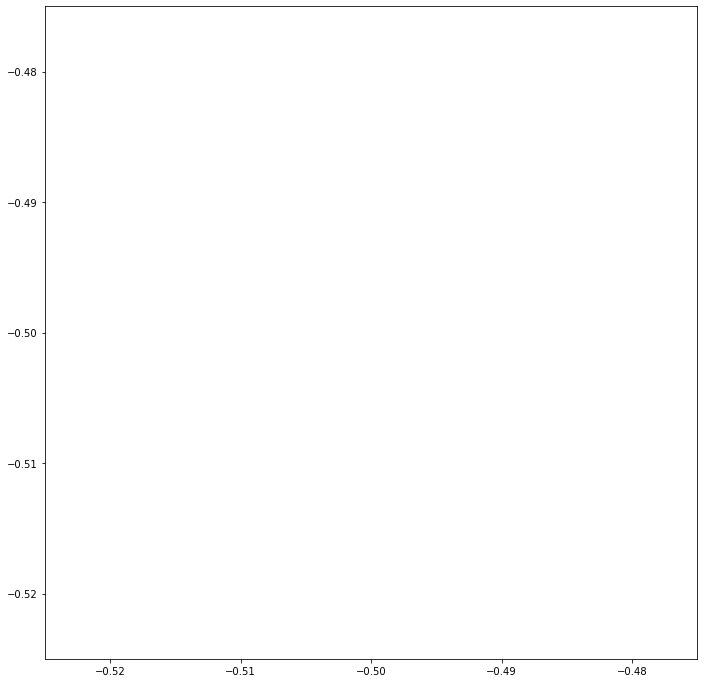

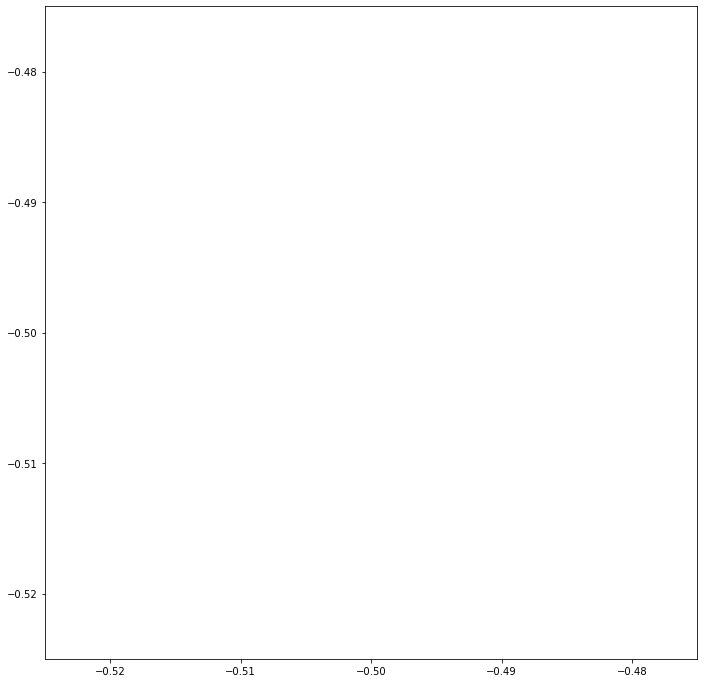

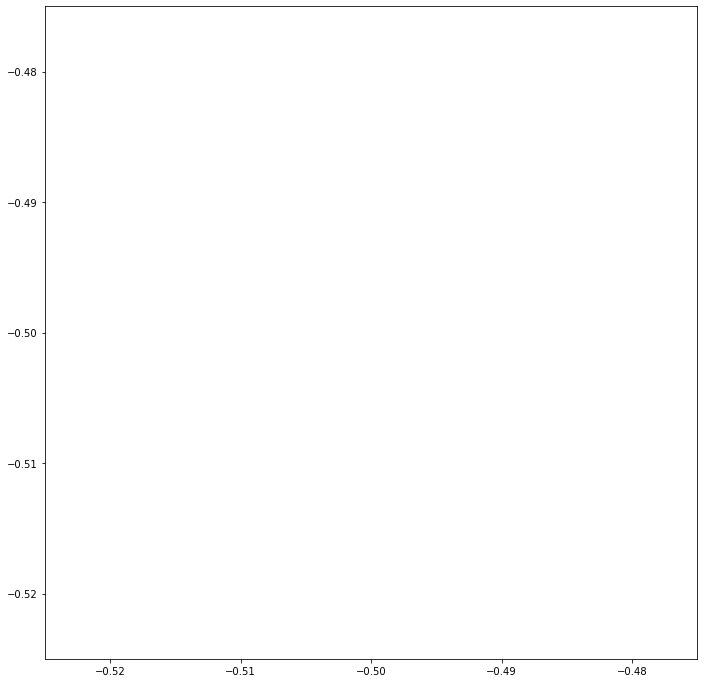

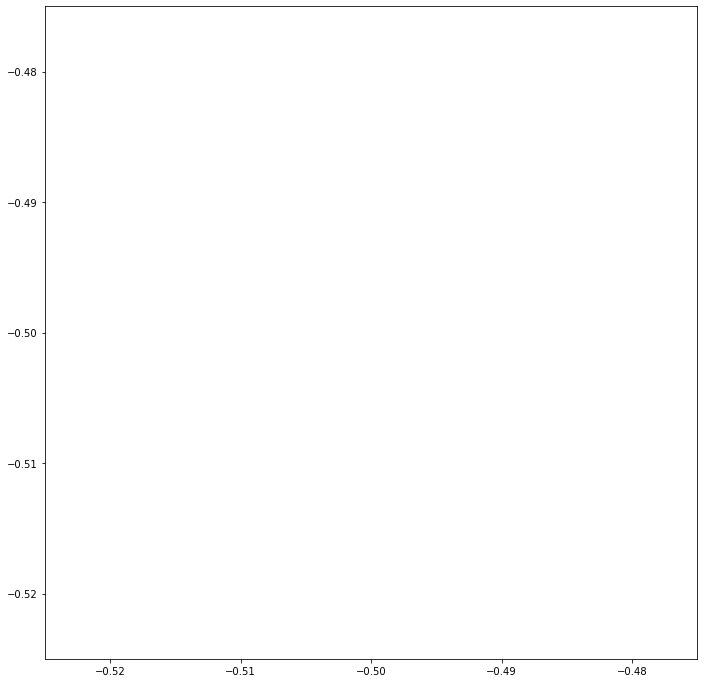

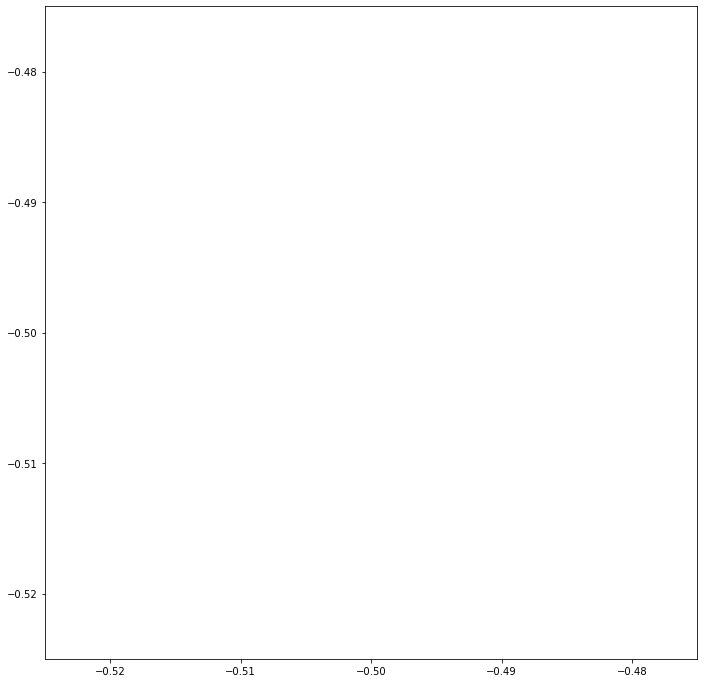

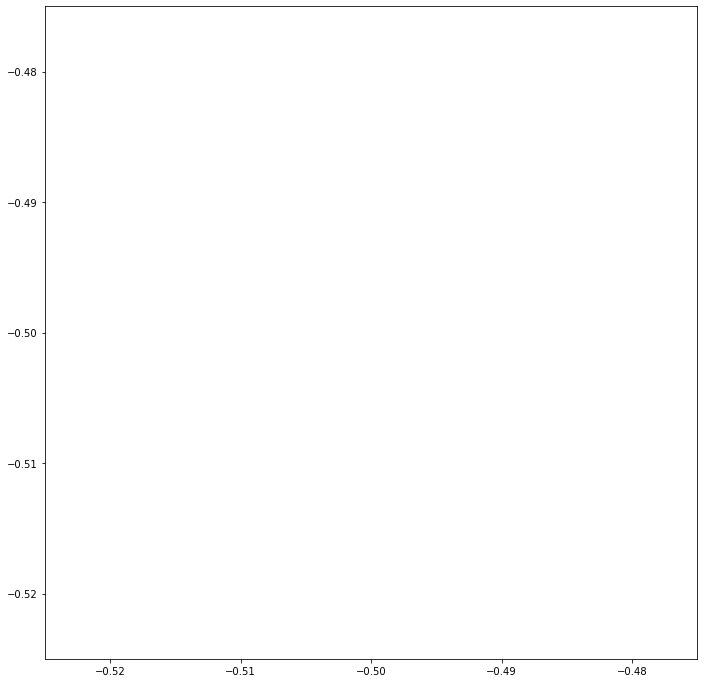

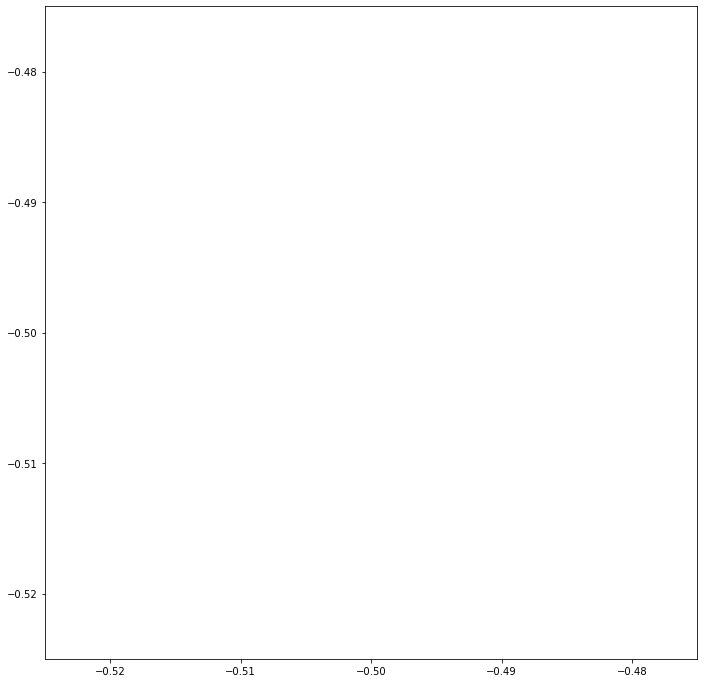

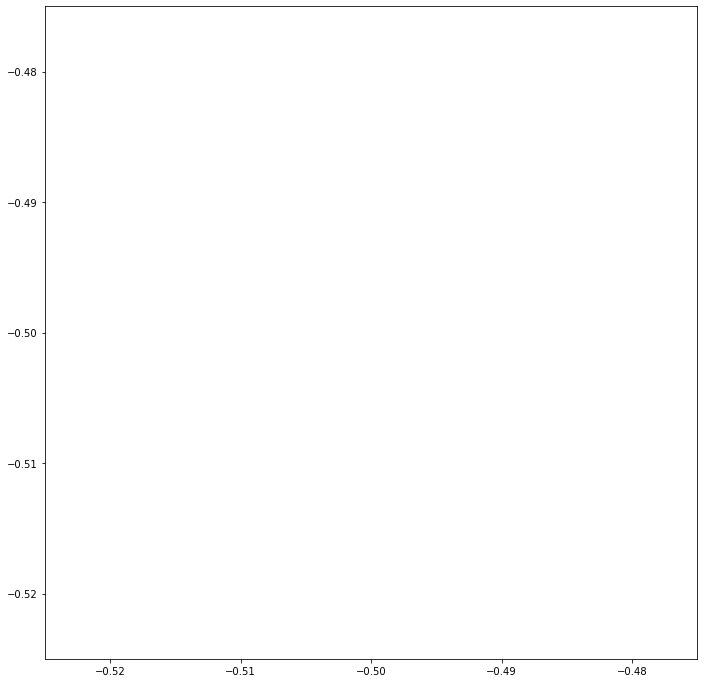

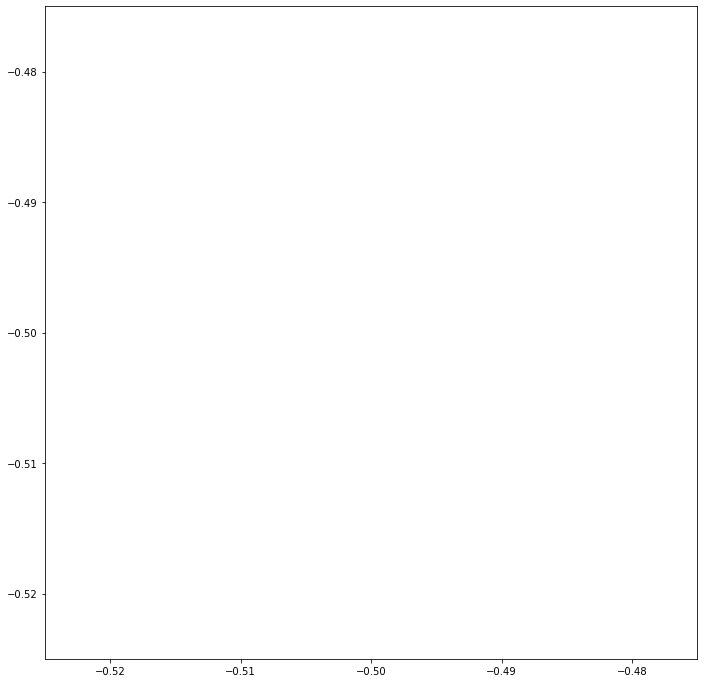

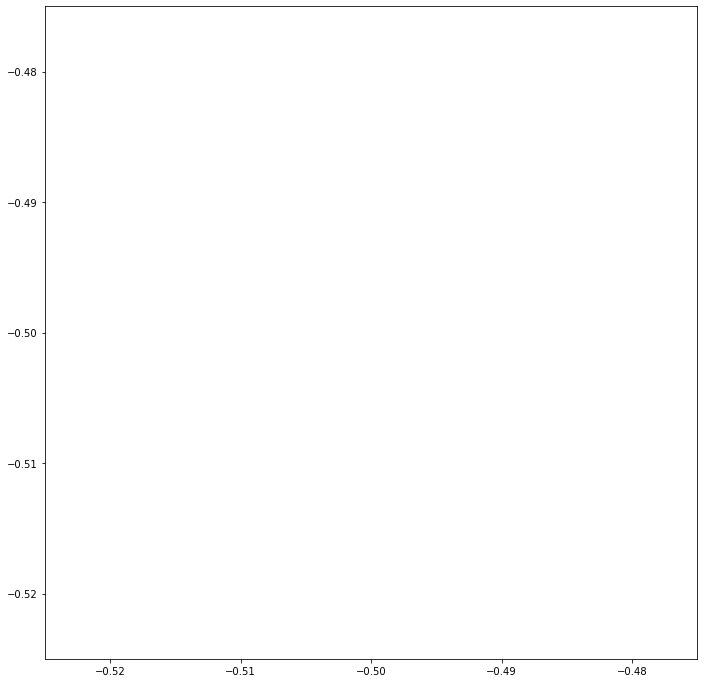

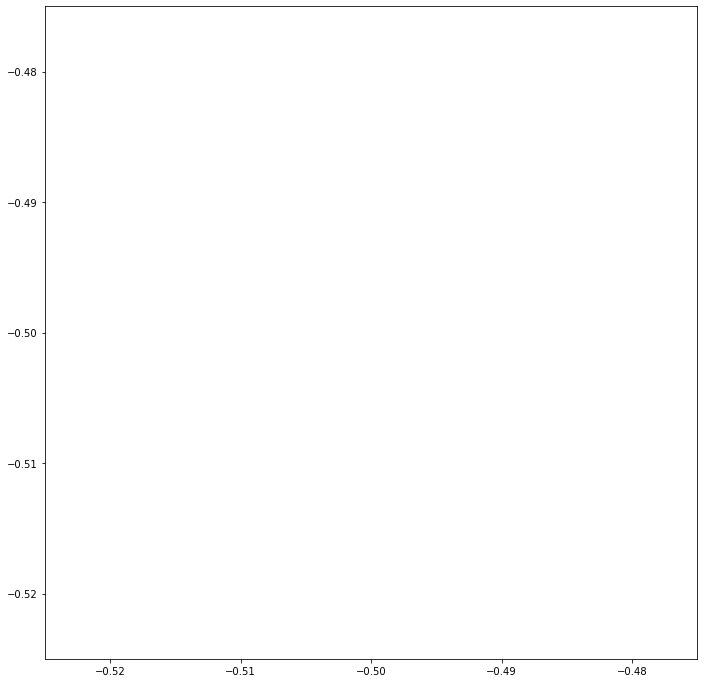

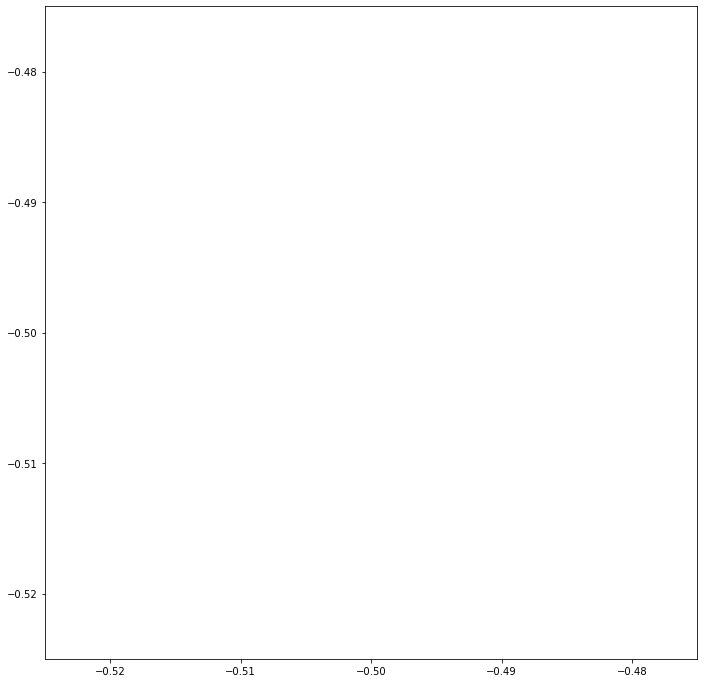

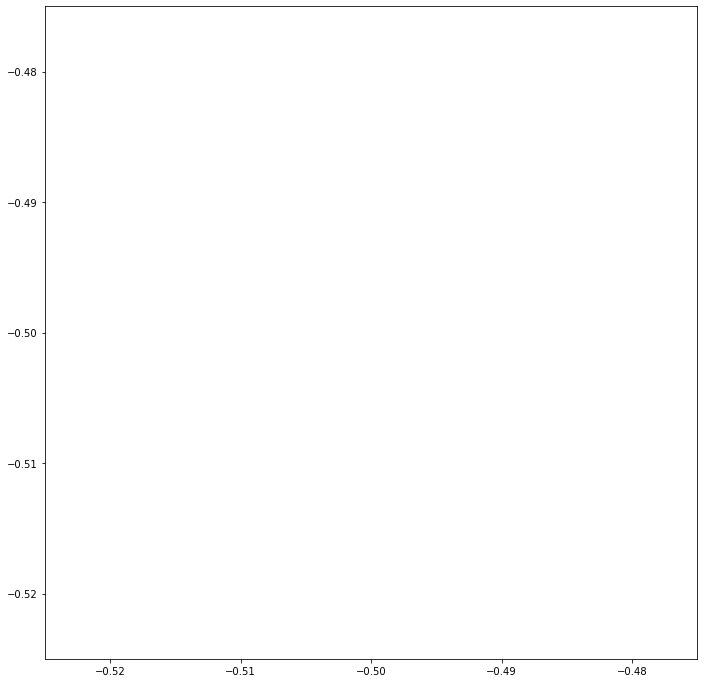

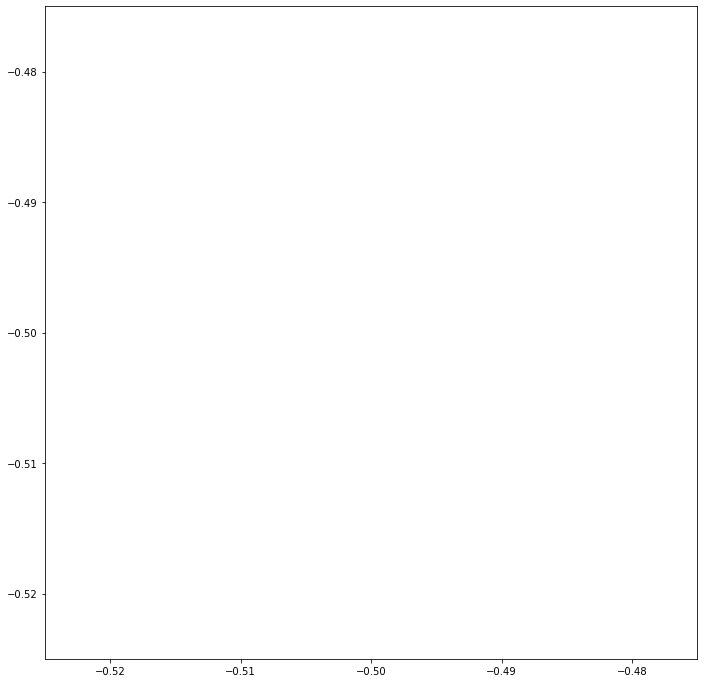

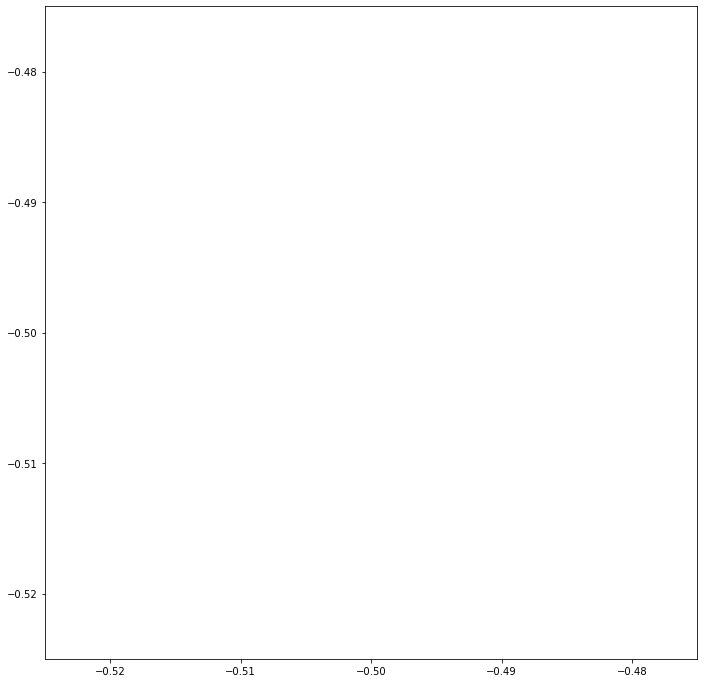

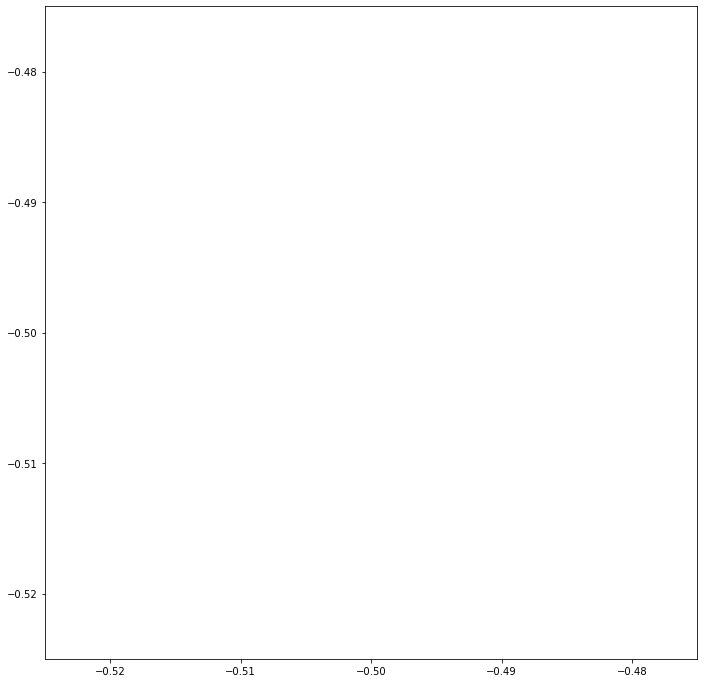

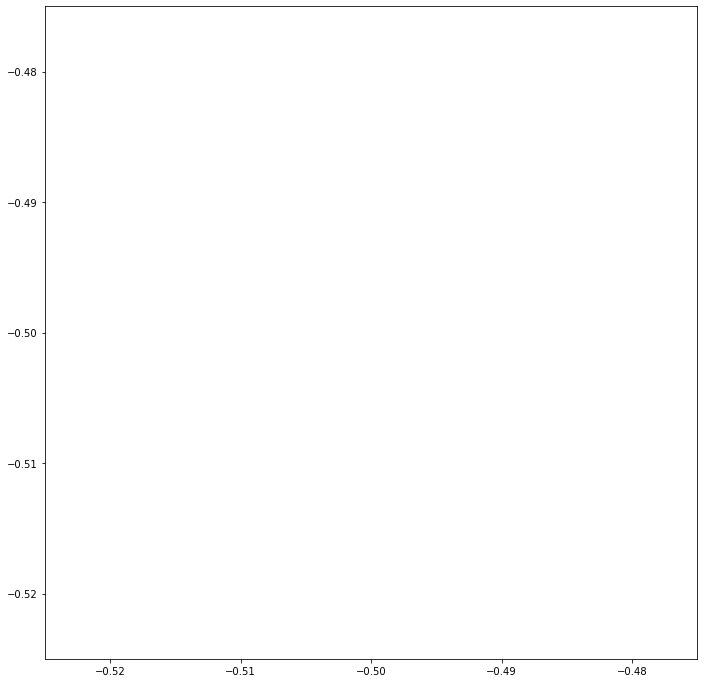

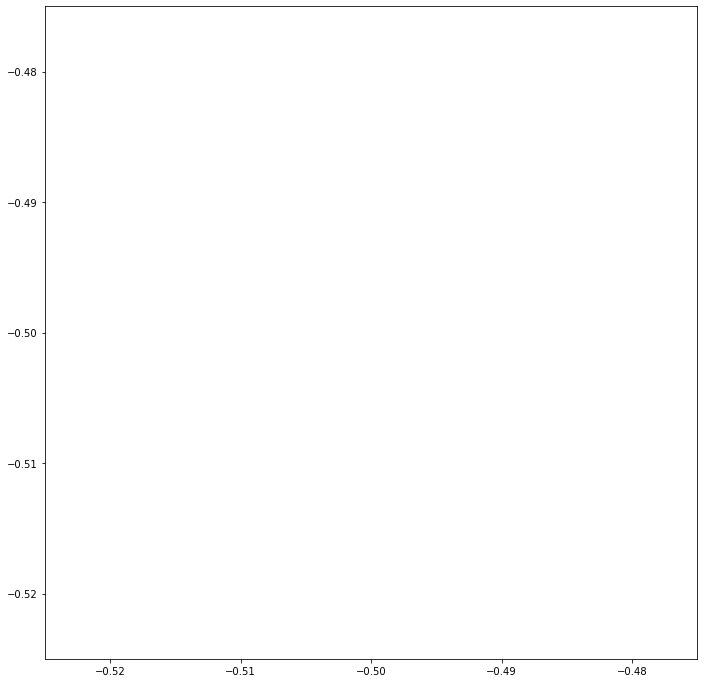

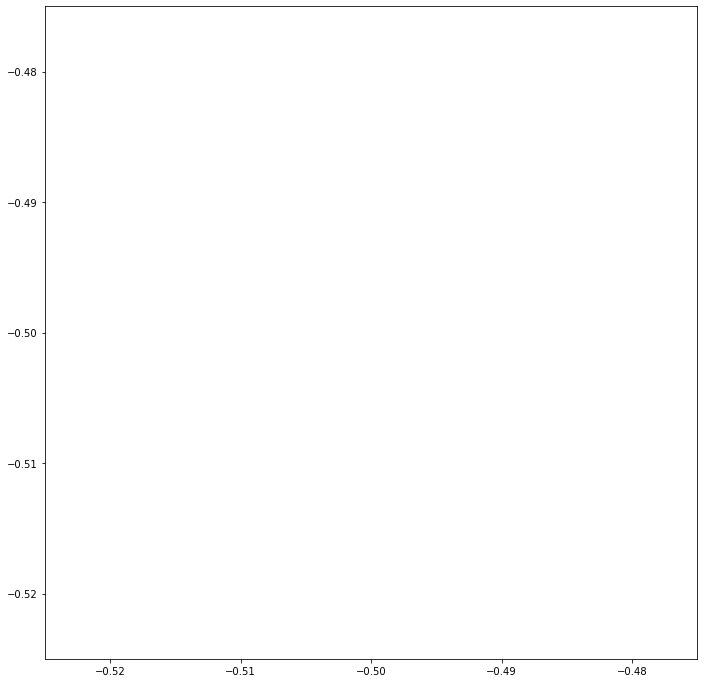

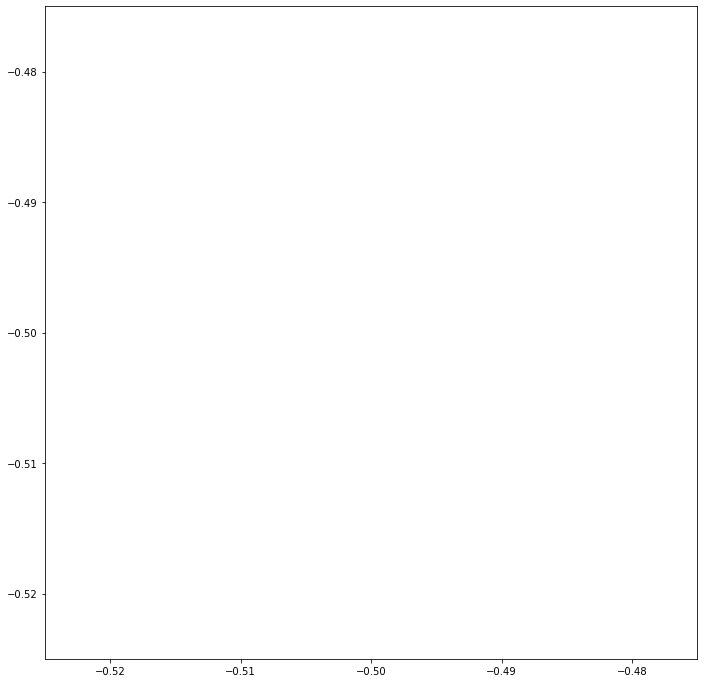

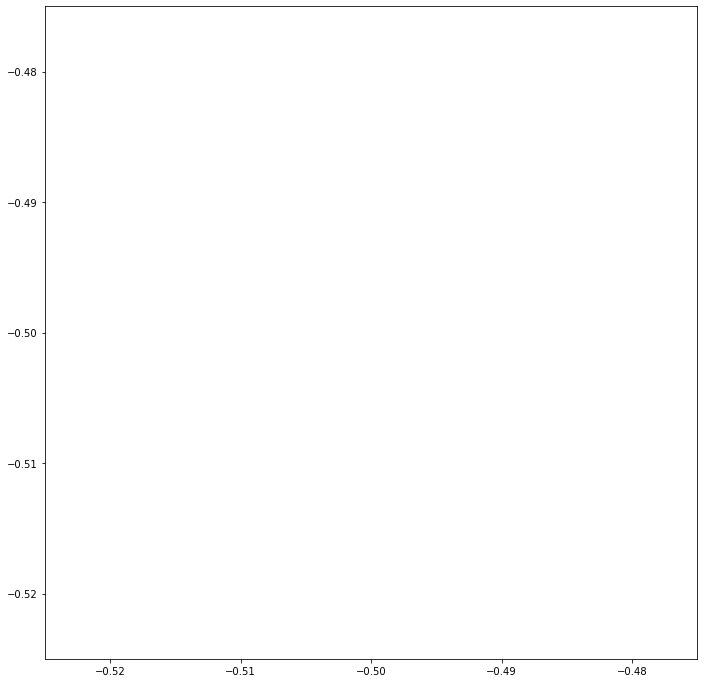

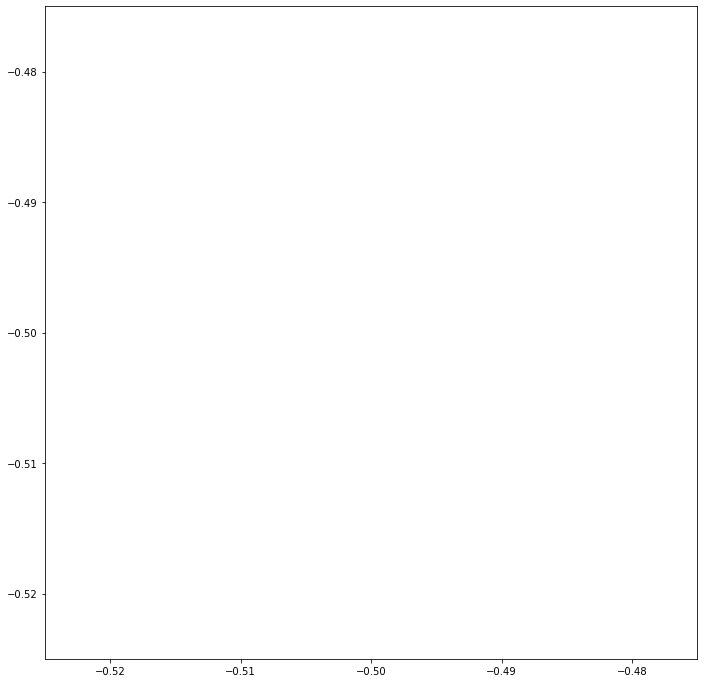

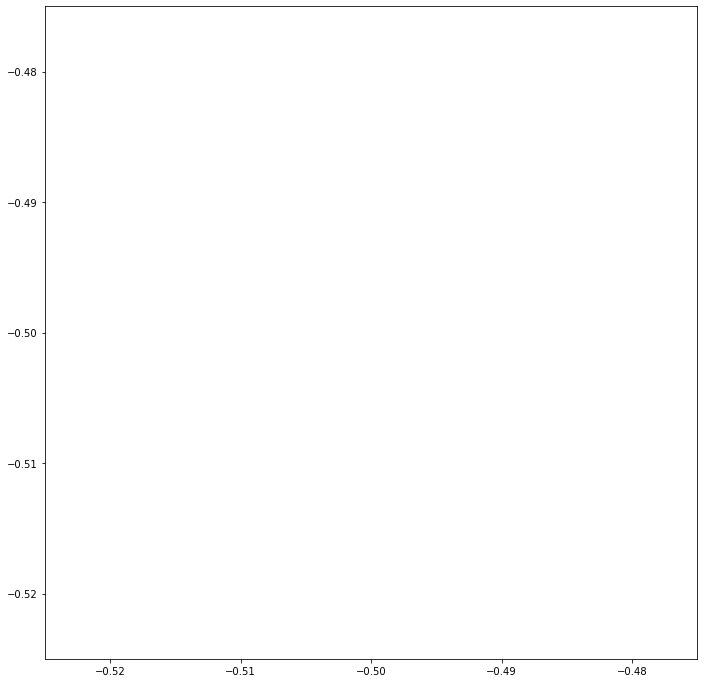

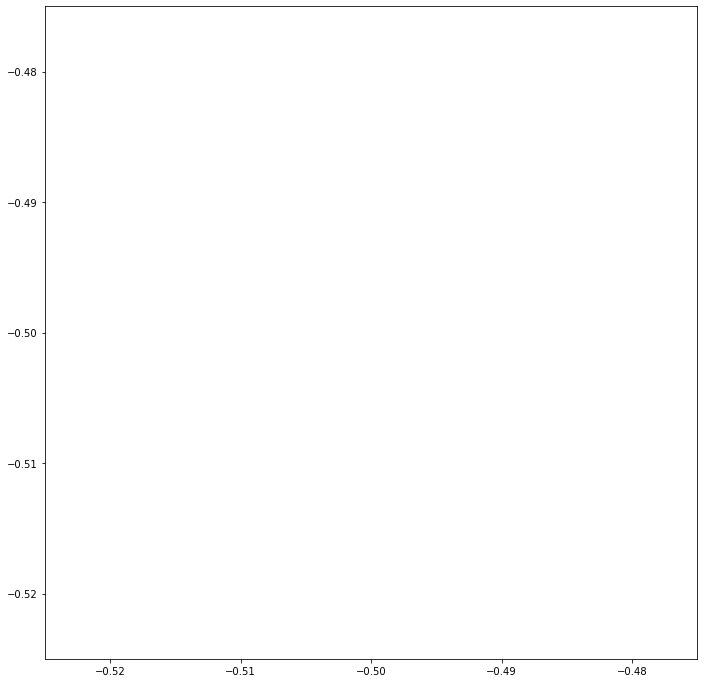

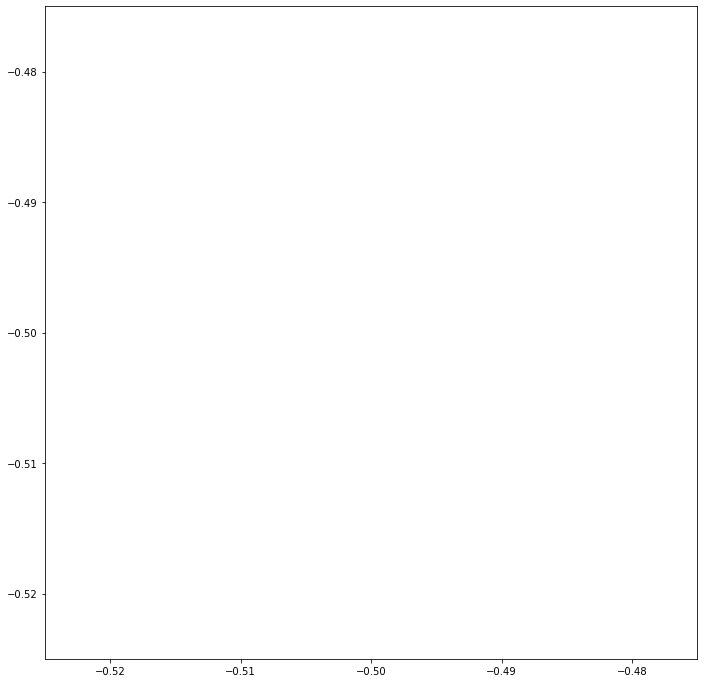

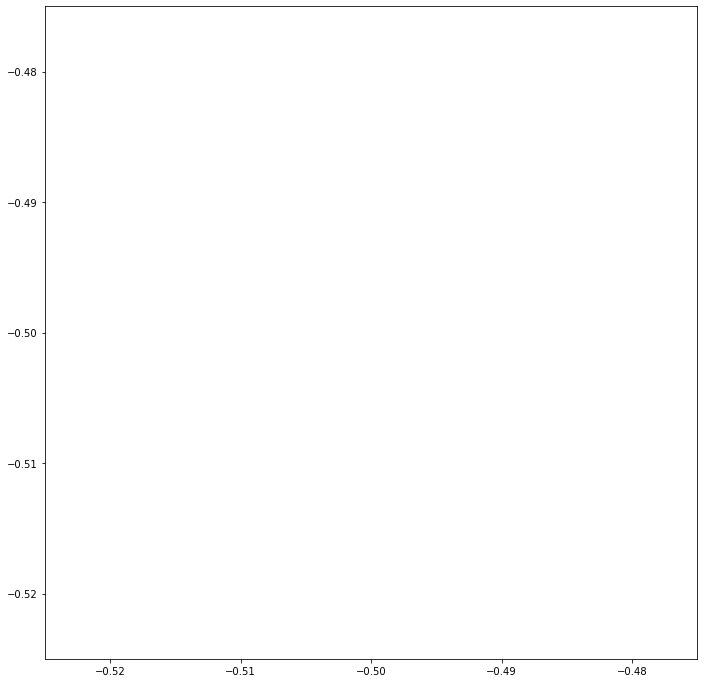

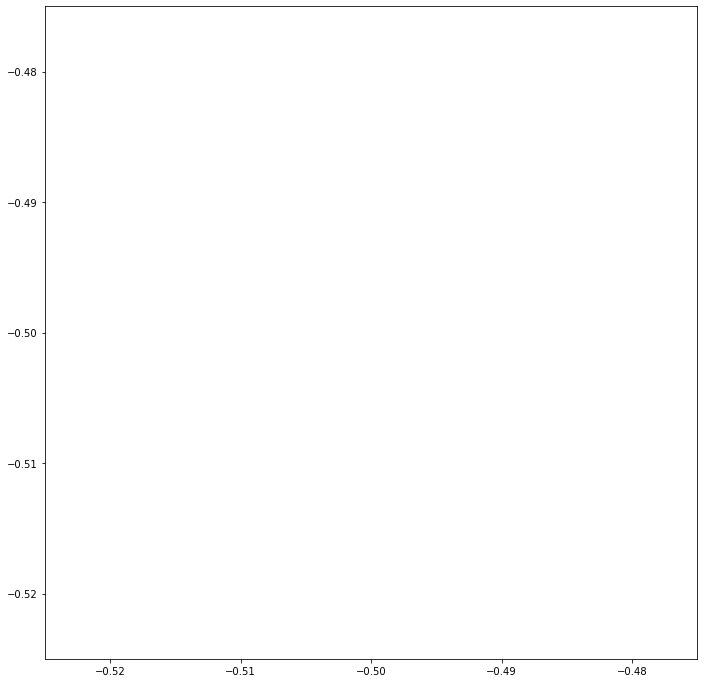

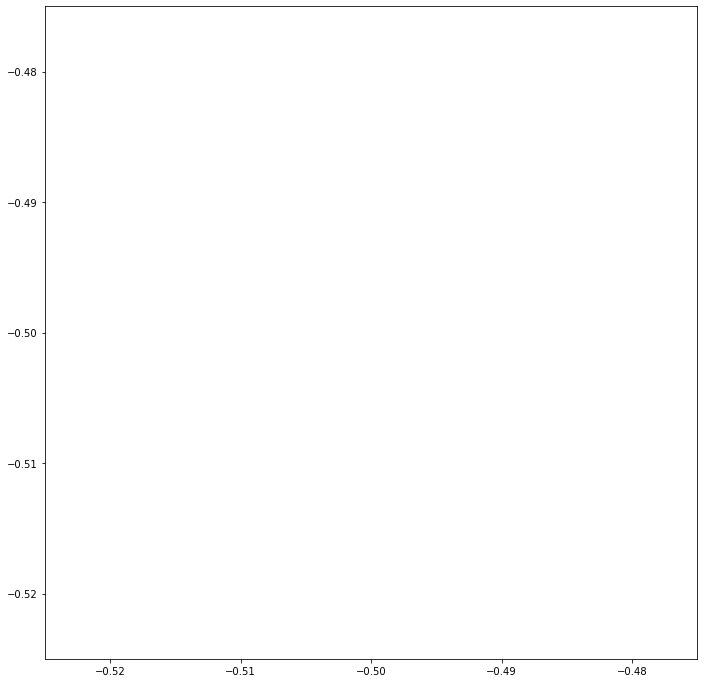

In [97]:
def cropMultipleContoursBindingRect(baseimg, cnts):
    #img = np.copy(baseimg)
    y1, x1 = img.shape
    x2 = 0
    y2 = 0
    for cnt in cnts:
        #cv2.drawContours(img, [cnt], -1, 255)
        x, y, w, h = cv2.boundingRect(cnt)
        if x < x1:
            x1 = x
        if y < y1:
            y1 = y
        if x2 < x + w:
            x2 = x + w
        if y2 < y + h:
            y2 = y + h
    w = x2 - x1
    h = y2 - y1
    rect = (x1, y1, w, h)
    return [rect , baseimg[int(y1):int(y1+h+1), int(x1):int(x1+w+1)]]
def rectDistance(r1, r2):
    ret = r2[0] - r1[0] - r2[2]
    return ret if ret >= 0 else 0
rois = []
baseimg = np.zeros(textimg.shape)
for rect in exrects:
    #char = cropMultipleContoursBindingRect(baseimg, rect[1])
    char = [rect[0], closedopentextimg[rect[0][1]:(rect[0][1]+rect[0][3]+1), rect[0][0]:(rect[0][0]+rect[0][2]+1)]]
    rois.append(char)
rois.sort(key=lambda x: x[0][0])
print(rois[0])
imgrois = []
distancerois = []
for i in range(0, len(rois)):
    imgrois.append(rois[i][1])
    plt.figure()
    plt.imshow(imgrois[i], 'gray')
    if i + 1 < len(rois):
        distancerois.append(rectDistance(rois[i][0], rois[i+1][0]))
print(distancerois)

30


/home/fmaster/anaconda3/envs/sc-jupy/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


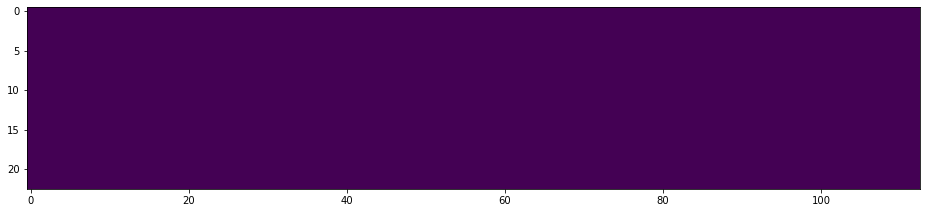

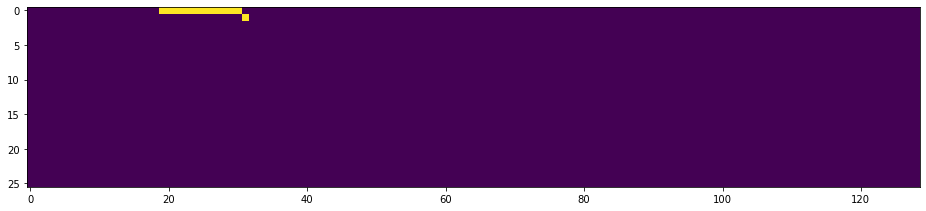

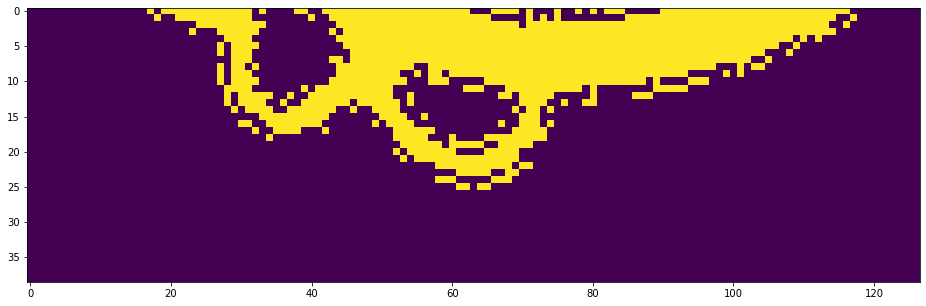

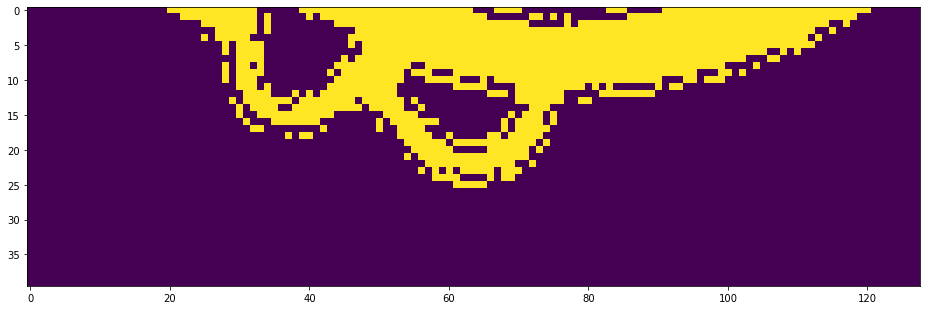

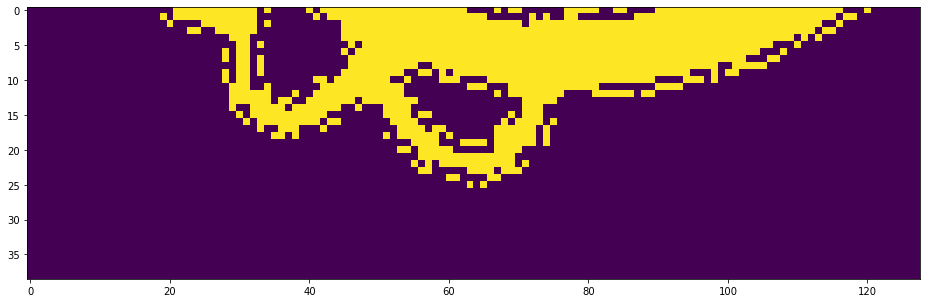

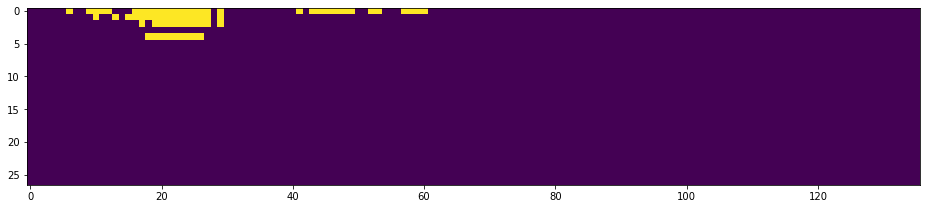

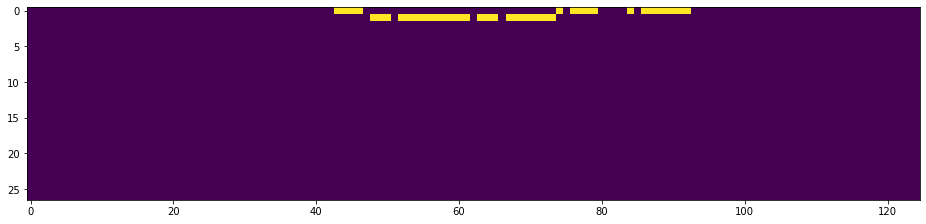

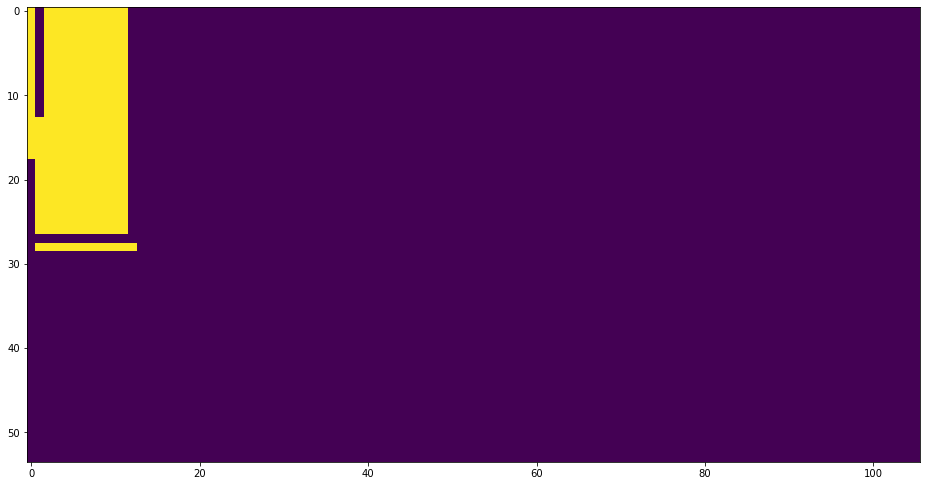

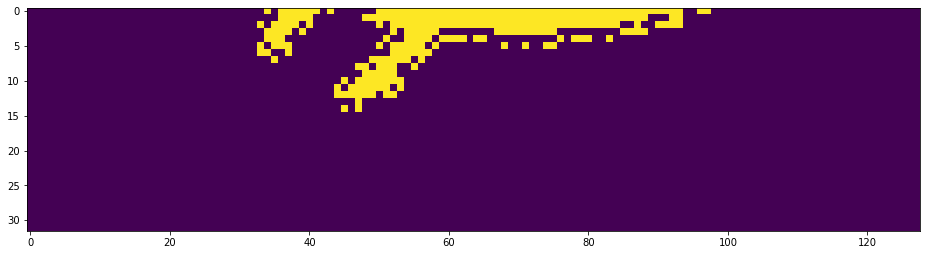

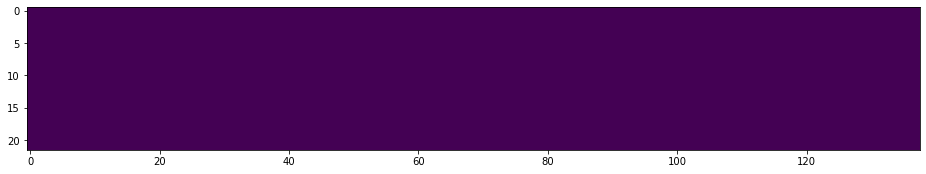

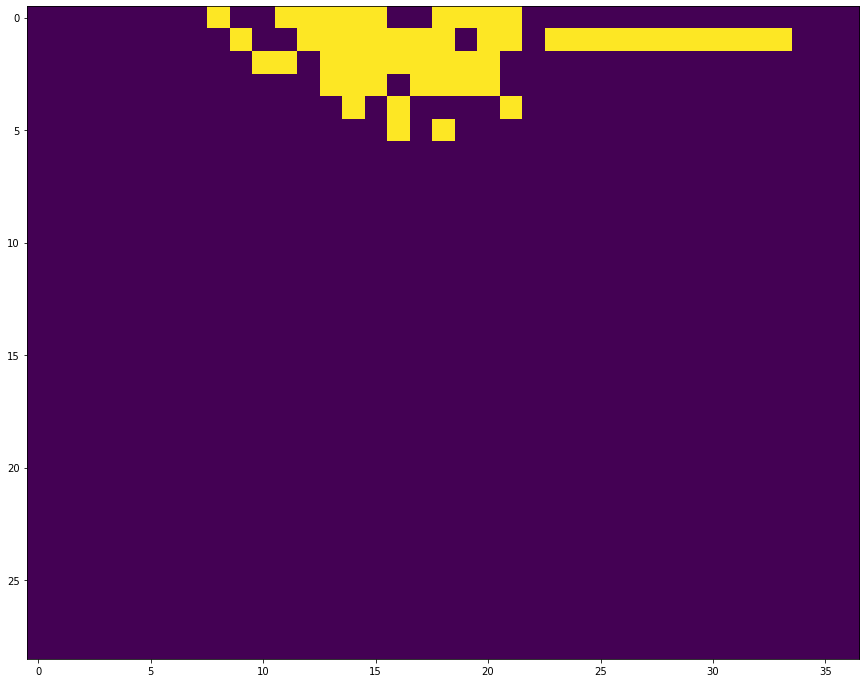

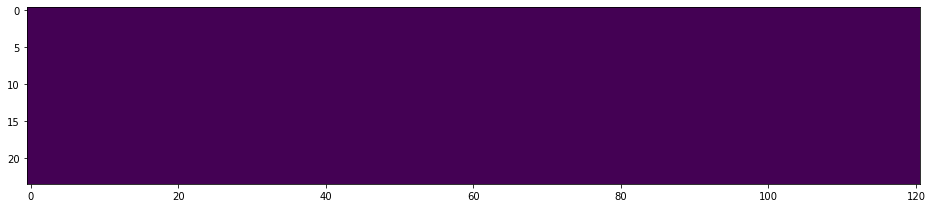

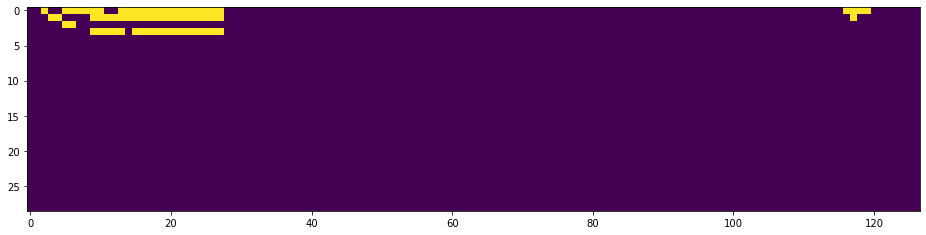

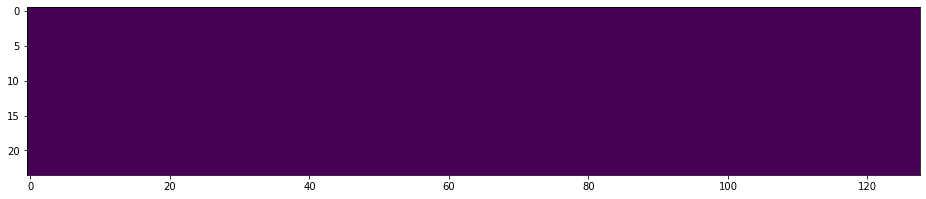

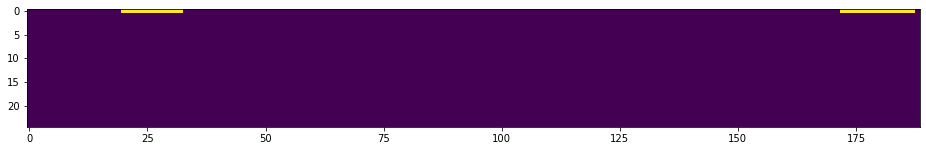

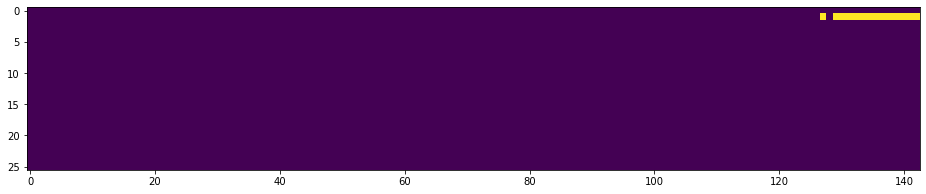

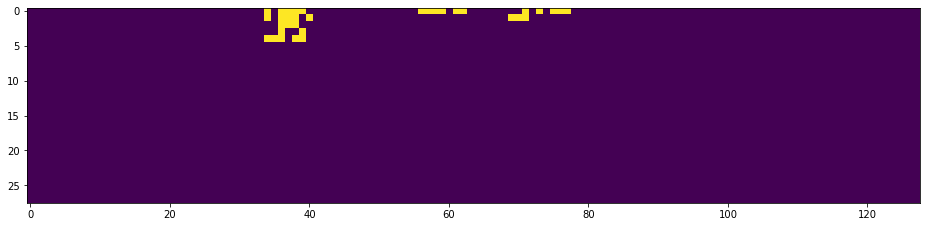

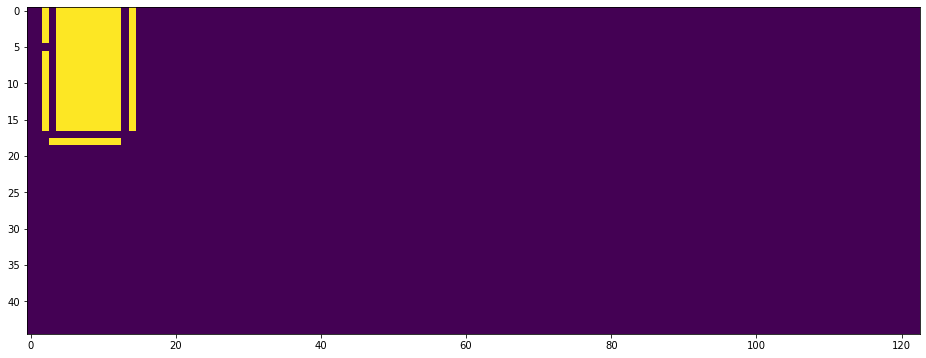

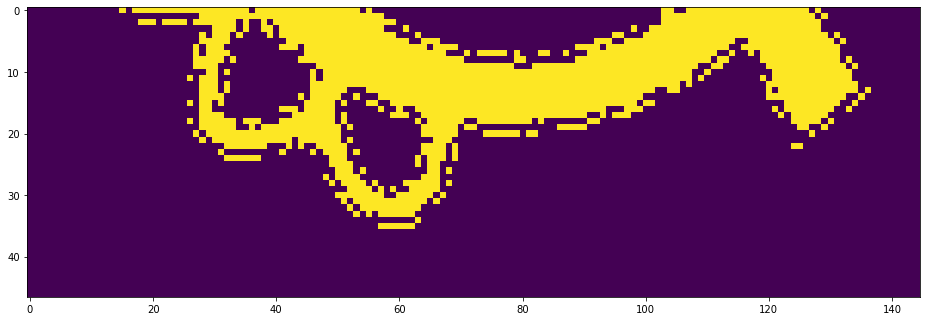

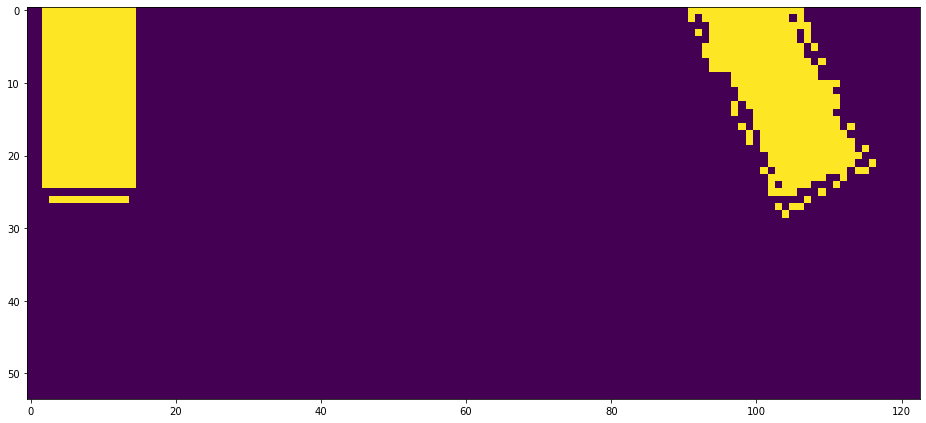

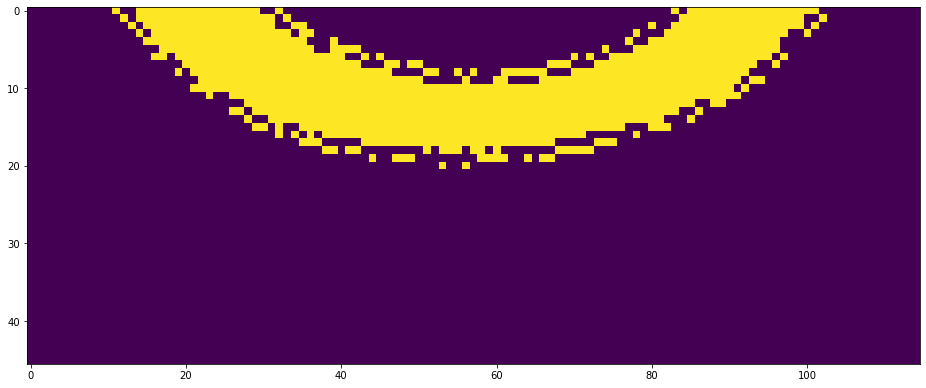

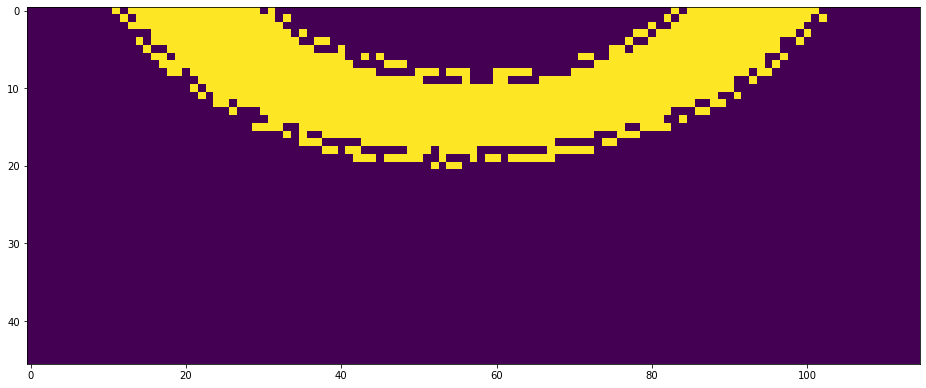

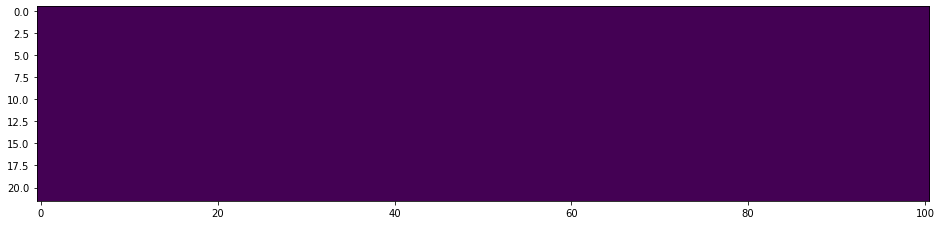

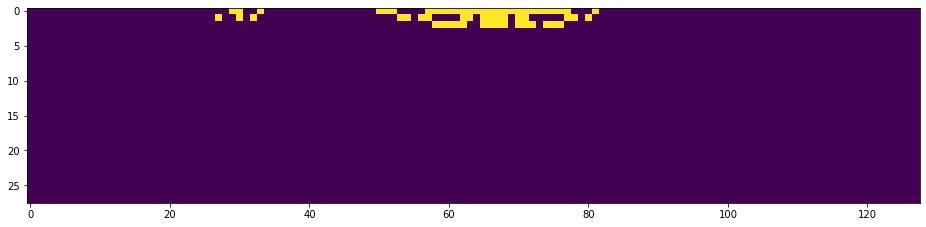

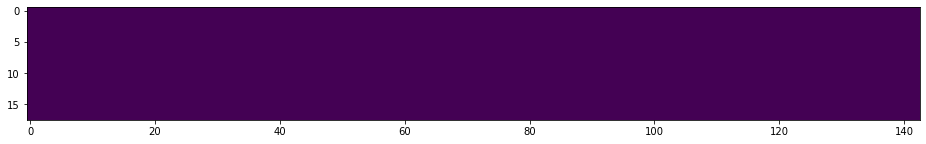

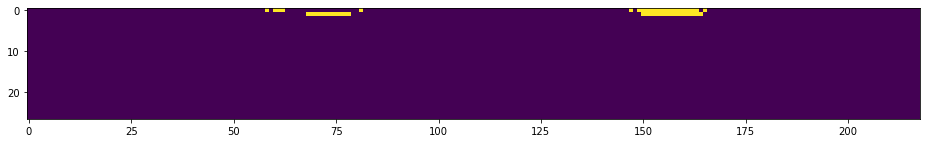

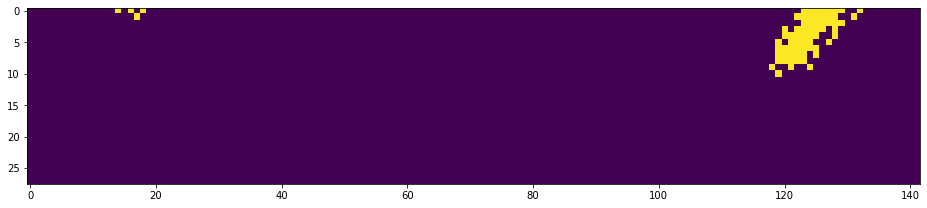

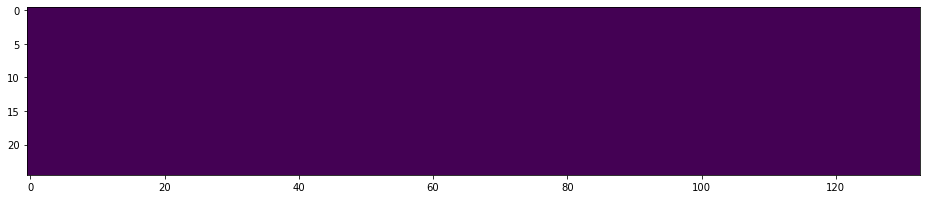

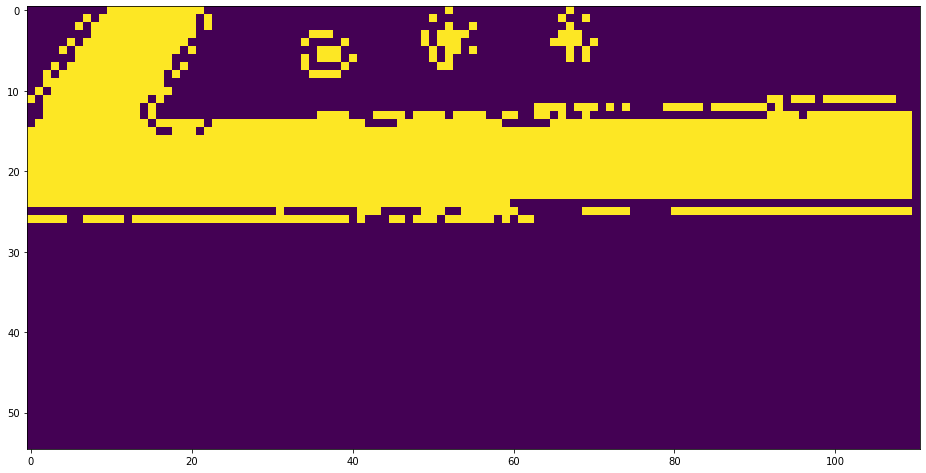

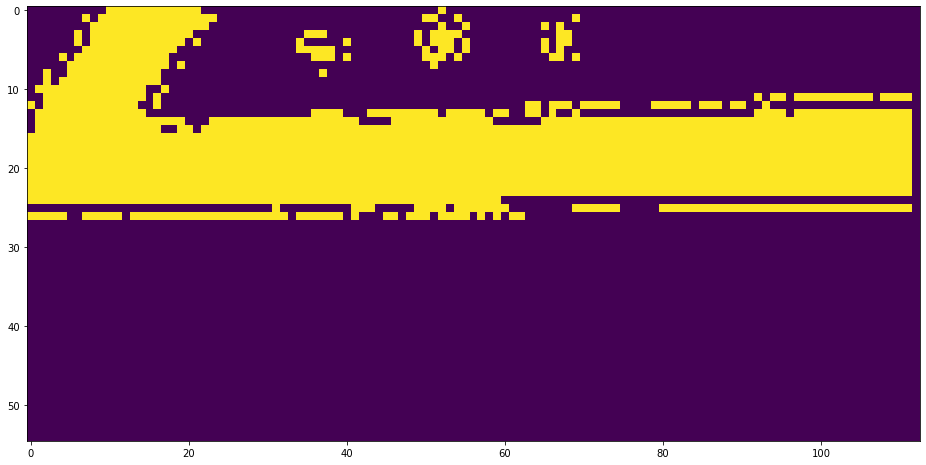

In [95]:
print(len(rois))
for roi in rois:
    plt.figure()
    plt.imshow(roi[1])
plt.show()

In [45]:
cv2.resize(rois[0][1], (32,32), interpolation = cv2.INTER_NEAREST)

array([[  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0, 255,   0],
       [  0,   0,   0, ...,   0, 255,   0],
       ...,
       [  0, 255, 255, ...,   0, 255, 255],
       [  0, 255, 255, ...,   0,   0, 255],
       [255, 255, 255, ...,   0,   0, 255]], dtype=uint8)

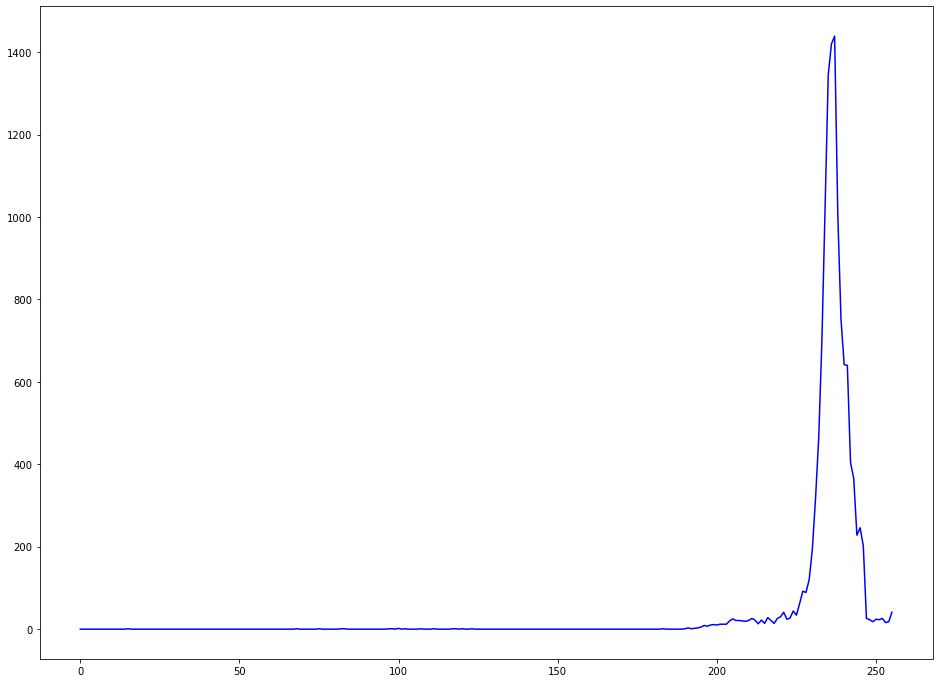

In [402]:
def hist(image):
    height, width = image.shape[0:2]
    x = range(0, 256)
    y = np.zeros(256)
    
    for i in range(0, height):
        for j in range(0, width):
            pixel = image[i, j]
            if pixel!=7: y[pixel] += 1
    
    return (x, y)
tmp = hsvImage.copy()
tmp[tmp[:,:,0]<99] = [0,0,7]
tmp[tmp[:,:,0]>99] = [0,0,7]
x,y = hist(tmp[:,:,2])

#print(tmp[:,:,1][tmp[:,:,1]==0])
plt.plot(x, y, 'b')
plt.show()

99


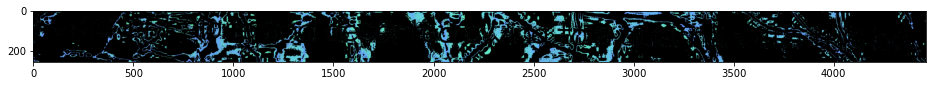

In [58]:
tmp = hsvImage.copy()
print(np.argmax(y))
tmp[tmp[:,:,0]!=np.argmax(y)] = [0,0,0]
#tmp[tmp[:,:,0]>50] = [0,0,0]
#tmp[tmp!=0] = 255
plt.imshow(tmp)

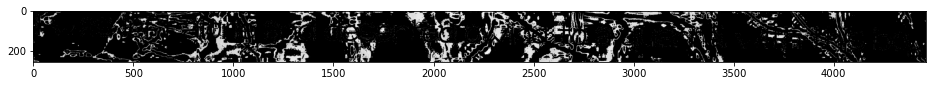

In [49]:
gsimg = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
plt.imshow(gsimg, 'gray')

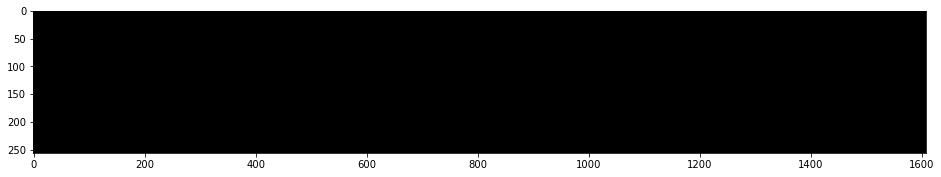

In [19]:
tmp = hsvImage.copy()
tmp[tmp<0] = 0
tmp[tmp>5] = 0
#tmp[tmp!=17] = 0
plt.imshow(tmp, 'gray')

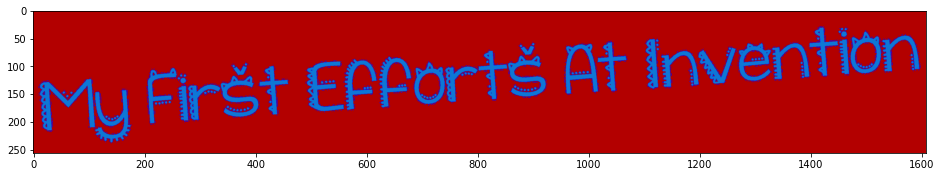

In [24]:
tmp = hsvImage.copy()
tmp[tmp[:,:,0]<10] = [179,0,0]
tmp[tmp[:,:,0]>50] = [179,0,0]
#tmp[tmp!=0] = 255
plt.imshow(tmp)

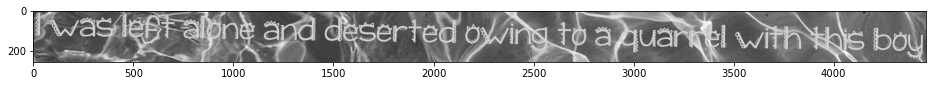

In [10]:
gsimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2GRAY)
plt.imshow(gsimg, 'gray')

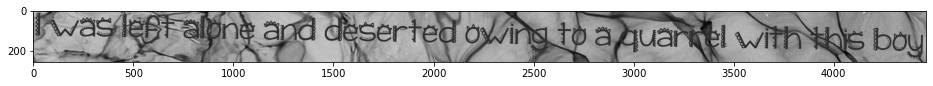

In [196]:
invimg = 255 - gsimg
plt.imshow(invimg, 'gray')

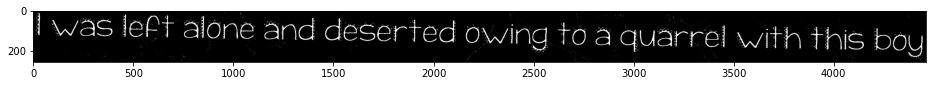

In [197]:
tmp = invimg.copy()
tmp[tmp<39] = 0
tmp[tmp>39] = 0
tmp[tmp!=0] = 255
plt.imshow(tmp, 'gray')

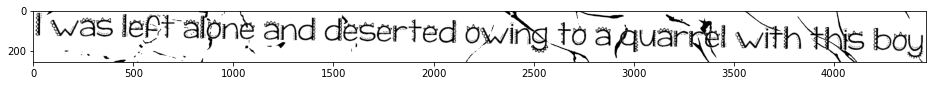

In [167]:
_, binimg = cv2.threshold(invimg, 40, 255, cv2.THRESH_BINARY)
plt.imshow(binimg, 'gray')

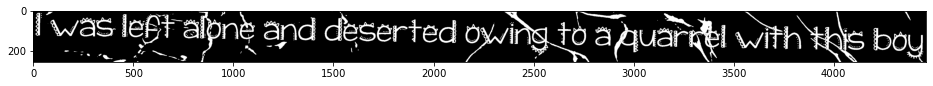

In [159]:
invbinimg = 255 - binimg
plt.imshow(invbinimg, 'gray')

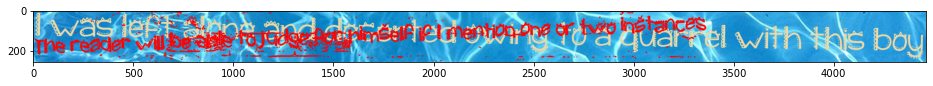

In [135]:
img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(rgbimg, contours, -1, (255, 0, 0), 3)
plt.imshow(rgbimg)